In [1]:
!pip install python_speech_features
!pip install python-dotenv 

In [2]:
!pip install keras --upgrade

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)


In [0]:
# !pip list librosa

In [4]:
import time
import numpy as np
import pandas as pd
from python_speech_features import mfcc
import os
from keras import layers
from keras import models
import keras
from keras import optimizers
from keras import regularizers
from keras import activations
from keras import backend as K
from keras.utils.data_utils import get_file

from sklearn.preprocessing import LabelEncoder, LabelBinarizer
import sys
sys.path.append('/content/drive/My Drive/cs577- Deep learning/deepMusic/')
import utils
from sklearn import preprocessing
import librosa
import matplotlib.pyplot as plt
import librosa.display
from sklearn.utils.class_weight import compute_class_weight
from math import floor


import tensorflow as tf
import keras.backend.tensorflow_backend as tfback
print("tf.__version__ is", tf.__version__)
print("tf.keras.__version__ is:", tf.keras.__version__)

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus



Using TensorFlow backend.


tf.__version__ is 2.2.0-rc3
tf.keras.__version__ is: 2.3.0-tf


In [0]:
# # Small dataset
# gen_params = {
#           'dim': (96,1366),
#           # 'dim': (96,469),
#           'batch_size': 10,
#           'n_classes': 4,
#           'n_channels': 1,
#           'shuffle': True}

# root_folder = '/content/drive/My Drive/cs577- Deep learning/deepMusic/'
# config = { 
#     'audio_dir' : root_folder + 'fma_small',
#     'tracks' : root_folder +'fma_metadata/subset_small.csv',
#     'generator_params': gen_params,
#     'audio_loader' : utils.FfmpegLoader()

# }


In [0]:
# Medium dataset
gen_params = {
          'dim': (96,1366),
          # 'dim': (96,469),
          'batch_size': 10,
          'n_classes': 4,
          'n_channels': 1,
          'shuffle': True}

root_folder = '/content/drive/My Drive/cs577- Deep learning/deepMusic/'
config = { 
    'audio_dir' : root_folder + 'fma_medium',
    'tracks' : root_folder +'fma_metadata/cleaned_medium.csv',
    'generator_params': gen_params,
    'audio_loader' : utils.FfmpegLoader()

}

In [0]:
# # Load npy files
# x_train = np.load(root_folder + "npy_files_new/medium/medium/x_train.npy")
# y_train = np.load(root_folder + "npy_files_new/medium/medium/y_train.npy")

# x_val = (np.load(root_folder + "npy_files_new/medium/medium/x_val.npy"))
# y_val = (np.load(root_folder + "npy_files_new/medium/medium/y_val.npy"))

# x_test = (np.load(root_folder + "npy_files_new/medium/medium/x_test.npy"))
# y_test = (np.load(root_folder + "npy_files_new/medium/medium/y_test.npy"))

# x_train = x_train.reshape((x_train.shape[0]*x_train.shape[1],x_train.shape[2],x_train.shape[3],x_train.shape[4]))
# x_val = x_val.reshape((x_val.shape[0]*x_val.shape[1],x_val.shape[2],x_val.shape[3],x_val.shape[4]))
# x_test = x_test.reshape((x_test.shape[0]*x_test.shape[1],x_test.shape[2],x_test.shape[3],x_test.shape[4]))

# y_train = y_train.reshape((y_train.shape[0]*y_train.shape[1],y_train.shape[2]))
# y_val = y_val.reshape((y_val.shape[0]*y_val.shape[1],y_val.shape[2]))
# y_test = y_test.reshape((y_test.shape[0]*y_test.shape[1],y_test.shape[2]))
# print(f'y_train -> {y_train.shape}')
# print(f'x_train -> {x_train.shape}')
# print(f'x_val -> {len(x_val)}')
# print(f'x_test -> {len(x_test)}')

In [0]:
def plot_mel_spect(spect):
    # spect = spect.flatten()
    # print(spect)
    plt.figure(figsize=(10, 5))
    librosa.display.specshow(spect.T, y_axis='mel', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Test Melspectogram')
    plt.show()

In [0]:
# plot_mel_spect(x_train[0][0])

In [9]:

from keras.models import load_model

weights_path = root_folder + 'models/crnn_20.h5'
model = load_model(weights_path)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 96, 1366)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 96, 1366)      80        
_________________________________________________________________
bn1 (BatchNormalization)     (None, 16, 96, 1366)      64        
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 16, 24, 341)       0         
_________________________________________________________________
dropout1 (AlphaDropout)      (None, 16, 24, 341)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 24, 341)       2080      
_________________________________________________________________
bn2 (BatchNormalization)     (None, 32, 24, 341)       128 

In [0]:
x_test = (np.load(root_folder + "npy_files_new/medium/medium/x_test.npy"))
y_test = (np.load(root_folder + "npy_files_new/medium/medium/y_test.npy"))

In [11]:
x_test = x_test.reshape((x_test.shape[0]*x_test.shape[1],x_test.shape[2],x_test.shape[3],x_test.shape[4]))
y_test = y_test.reshape((y_test.shape[0]*y_test.shape[1],y_test.shape[2]))
y_test = np.argmax(y_test, axis=1)
x_test.shape, y_test.shape

print(np.unique(y_test))

[0 1 2 3]


In [12]:
# y_test -= 1
print(np.amin(y_test), np.amax(y_test), np.mean(y_test))

X_test_raw = librosa.core.db_to_power(x_test, ref=1.0)
print(np.amin(X_test_raw), np.amax(X_test_raw), np.mean(X_test_raw))

0 3 1.616030534351145
1e-08 1.0 0.00019223616009502088


In [0]:

X_test = np.log(X_test_raw)
X_test = np.expand_dims(X_test, axis = -1)

In [14]:
print(y_test[:5])

[3 0 0 0 0]


In [15]:
!pip install keras-vis
!pip install scipy==1.1.0

In [0]:
from vis.visualization import visualize_activation
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

layer_idx = utils.find_layer_idx(model, 'output')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)


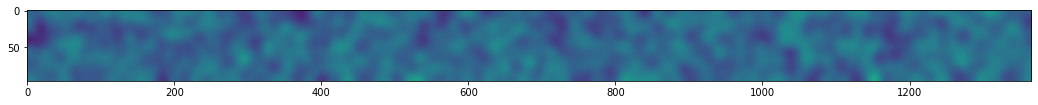

In [17]:
K.set_image_data_format('channels_first')
filters=[]
#layer_idx = utils.find_layer_idx(model, 'preds')
layer_idx = utils.find_layer_idx(model, 'conv1')
# This is the output node we want to maximize.
# for filter_idx in range(16):
plt.rcParams['figure.figsize'] = (18, 6)
img = visualize_activation(model, layer_idx, filter_indices=8)
filters.append(img)
plt.imshow(img[..., 0])
    #lt.savefig(str(filter_idx)+'.png')

Num Filters is:  32
Stitched shape:  (3227, 1366)


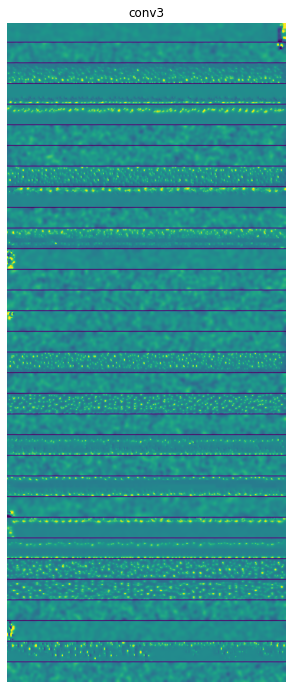

In [18]:
from vis.visualization import get_num_filters
import cv2
from sklearn.metrics import classification_report, confusion_matrix

K.set_image_data_format('channels_first')

# The name of the layer we want to visualize
# You can see this in the model definition.
layer_name = 'conv3'
layer_idx = utils.find_layer_idx(model, layer_name)

# Visualize all filters in this layer.
filters = np.arange(get_num_filters(model.layers[layer_idx]))
print("Num Filters is: ", filters[-1]+1)
# Generate input image for each filter.
vis_images = []
for idx in filters:
    img = visualize_activation(model, layer_idx, filter_indices=idx)
    
    # Utility to overlay text on image.
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img,str(idx),(50,50), font, 2,(0,0,0),2) 
    vis_images.append(img)

# Generate stitched image palette with 8 cols.
stitched = utils.stitch_images(vis_images, cols=1)
stitched = stitched.reshape(stitched.shape[0], stitched.shape[1])
print("Stitched shape: ", stitched.shape)
plt.rcParams['figure.figsize'] = (5, 15)
plt.axis('off')
plt.imshow(stitched)
plt.title(layer_name)
plt.show()

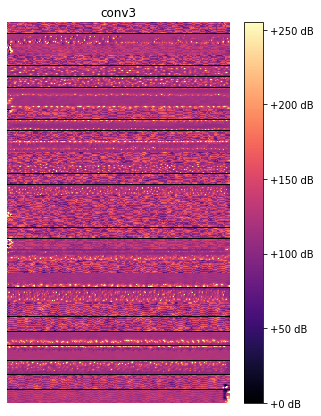

In [19]:
plt.rcParams['figure.figsize'] = (5, 7)
plt.axis('off')
librosa.display.specshow(stitched, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
# plt.imshow(stitched)
plt.title(layer_name)
plt.show()